In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! ln -s /content/drive/MyDrive/XAI-CV-CounterfactualSamples .
# ! ln -s /content/drive/MyDrive/src/XAI-CV-CounterfactualSamples .

ln: failed to create symbolic link './XAI-CV-CounterfactualSamples': Operation not supported


In [ ]:
%cd XAI-CV-CounterfactualSamples

[Errno 2] No such file or directory: 'XAI-CV-CounterfactualSamples'
/content/drive/.shortcut-targets-by-id/1FmCtSVnfeWpfBgto3qiAc-ottQsooZSc/XAI-CV-CounterfactualSamples/exp_breakhis


In [ ]:
# ! ln -s /content/drive/MyDrive/datasets/BreakHis_v1 datasets

In [ ]:
%cd exp_breakhis

[Errno 2] No such file or directory: 'exp_breakhis'
/content/drive/.shortcut-targets-by-id/1FmCtSVnfeWpfBgto3qiAc-ottQsooZSc/XAI-CV-CounterfactualSamples/exp_breakhis


In [ ]:
! pip install tensorflow==2.15.1 > /content/install.log

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.17.0 requires tensorflow<2.18,>=2.17, but you have tensorflow 2.15.1 which is incompatible.


# Initialization

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

print(tf.__version__)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import importlib
import configs
importlib.reload(configs)

# Data Loader

In [ ]:
class MyDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data_dir, subsets_file, subset,
                       batch_size=32, shuffle=False):
        self.data_dir = data_dir
        self.subsets_file = subsets_file
        self.subset = subset
        self.batch_size = batch_size
        self.shuffle = shuffle

        self.filenames = None
        self.classnames = None
        self.dict_class_names = None

        self.load_data()
        self.indices = None
        self.on_epoch_end()

    def load_data(self):
        df_files = pd.read_csv(self.subsets_file, header='infer')
        self.df_files = df_files[df_files['grp'] == self.subset]
        self.filenames = self.df_files['filename'].tolist()
        self.classnames = self.df_files['classname'].tolist()
        self.dict_class_names = {name:i for i, name in enumerate(configs.CLASS_NAMES)}
        print('*** load_data')
        print(self.subset)
        print(len(self.filenames), 'found')
        print(df_files.head())
        print('***')

    def __len__(self):
        return int(np.ceil(len(self.filenames) / self.batch_size))

    def __getitem__(self, index):
        indices = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        filenames = [self.filenames[k] for k in indices]
        classnames = [self.classnames[k] for k in indices]
        X, Y = self.__data_generation(filenames, classnames)
        return X, Y

    def on_epoch_end(self):
        self.indices = np.arange(len(self.filenames))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

    def toOneHot(self, classname):
        v = np.zeros(configs.NUM_CLASS, dtype=np.float64)
        v[self.dict_class_names[classname]] = 1.0
        return v

    def __data_generation(self, filenames, classnames):
        num = len(filenames)
        X = np.empty([num, *configs.IMAGE_SIZE], dtype=np.float64)
        Y = np.empty([num, configs.NUM_CLASS])
        HH, WW, _ = configs.IMAGE_SIZE
        for i, fn in enumerate(filenames):
            img = plt.imread(configs.DATA_DIR+'/'+fn)
            delta = (WW - HH) // 2
            img = img[:, delta:WW-delta-1]
            img = cv2.resize(img, configs.IMAGE_SIZE[:2])
            X[i] = np.array(img, dtype=np.float64)
            Y[i] = self.toOneHot(classnames[i])

        return X, Y

In [ ]:
train_datagen = MyDataGenerator(configs.DATA_DIR,
                                configs.SUBSETS_FILE,
                                'train',
                                shuffle=True)
val_datagen = MyDataGenerator(configs.DATA_DIR,
                              configs.SUBSETS_FILE,
                              'val',
                              shuffle=False)
test_datagen = MyDataGenerator(configs.DATA_DIR,
                               configs.SUBSETS_FILE,
                               'test',
                               shuffle=False)

*** load_data
train
4000 found
   mag    grp                                           filename  \
0   40  train  malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-1...   
1  400  train  malignant/SOB/ductal_carcinoma/SOB_M_DC_14-110...   
2  100  train  benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SO...   
3  100  train  malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-1...   
4   40  train  benign/SOB/adenosis/SOB_B_A_14-22549CD/40X/SOB...   

            classname  
0  mucinous_carcinoma  
1    ductal_carcinoma  
2            adenosis  
3  mucinous_carcinoma  
4            adenosis  
***
*** load_data
val
1000 found
   mag    grp                                           filename  \
0   40  train  malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-1...   
1  400  train  malignant/SOB/ductal_carcinoma/SOB_M_DC_14-110...   
2  100  train  benign/SOB/adenosis/SOB_B_A_14-22549CD/100X/SO...   
3  100  train  malignant/SOB/mucinous_carcinoma/SOB_M_MC_14-1...   
4   40  train  benign/SOB/adenosis/SOB_B_A_

(32, 256, 256, 3) (32, 8)


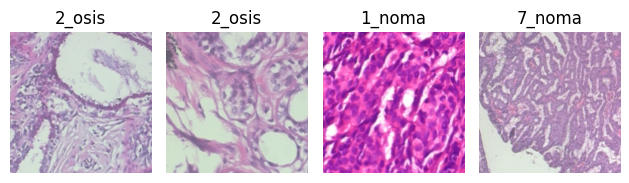

In [ ]:
X, Y = train_datagen[0]
print(X.shape, Y.shape)

for i in range(4):
  plt.subplot(1, 4, i+1)
  plt.imshow((X[i]*255).astype(np.uint8))
  plt.axis('off')
  class_id = Y[i].argmax()
  plt.title(str(class_id)+'_'+configs.CLASS_NAMES[class_id][-4:])
plt.tight_layout()
plt.show()

# Classifer 256 x 256

In [ ]:
model = tf.keras.models.Sequential(name='classifier256')
model.add(tf.keras.applications.resnet50.ResNet50(
            include_top=False,
            weights='imagenet',
            input_shape=configs.IMAGE_SIZE)
)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(configs.NUM_CLASS, activation='sigmoid'))
model.add(tf.keras.layers.Softmax())
model.summary()

94765736/94765736 [==============================] - 0s 0us/step
Model: "classifier256"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 8)                 16392     
                                                                 
 softmax (Softmax)           (None, 8)                 0         
                                                                 
Total params: 23604104 (90.04 MB)
Trainable params: 23550984 (89.84 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
model.compile(optimizer=tf.optimizers.Adam(learning_rate=1e-4),
              loss=tf.losses.CategoricalCrossentropy(),
              metrics=['accuracy'])

# Training

In [ ]:
cb_early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=1e-4,
    patience=5,
    verbose=1,
    mode='auto'
)
cb_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    configs.CHECKPOINTS_DIR + '/' + model.name + '/',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='auto'
)
cb_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=1e-4,
    min_lr=0
)

callbacks = [cb_model_checkpoint,
             cb_reduce_lr,
             cb_early_stop]

In [ ]:
history = model.fit_generator(train_datagen,
                    epochs=2024,
                    verbose=1,
                    callbacks=callbacks,
                    validation_data=val_datagen)

pd.DataFrame.from_dict(history.history) \
            .to_csv(configs.CHECKPOINTS_DIR+'/'+
                    model.name+'/history_classifier.csv',
                    index=False)

Epoch 1/2024
125/125 [==============================] - ETA: 0s - loss: 1.6053 - accuracy: 0.6258 
Epoch 1: val_loss improved from inf to 2.01115, saving model to checkpoints//classifier256/
125/125 [==============================] - 2536s 20s/step - loss: 1.6053 - accuracy: 0.6258 - val_loss: 2.0112 - val_accuracy: 0.4170 - lr: 1.0000e-04
Epoch 2/2024
125/125 [==============================] - ETA: 0s - loss: 1.4051 - accuracy: 0.8375
Epoch 2: val_loss improved from 2.01115 to 1.96875, saving model to checkpoints//classifier256/
125/125 [==============================] - 85s 679ms/step - loss: 1.4051 - accuracy: 0.8375 - val_loss: 1.9687 - val_accuracy: 0.4170 - lr: 1.0000e-04
Epoch 3/2024
125/125 [==============================] - ETA: 0s - loss: 1.3595 - accuracy: 0.8900
Epoch 3: val_loss improved from 1.96875 to 1.91845, saving model to checkpoints//classifier256/
125/125 [==============================] - 85s 680ms/step - loss: 1.3595 - accuracy: 0.8900 - val_loss: 1.9184 - val_ac

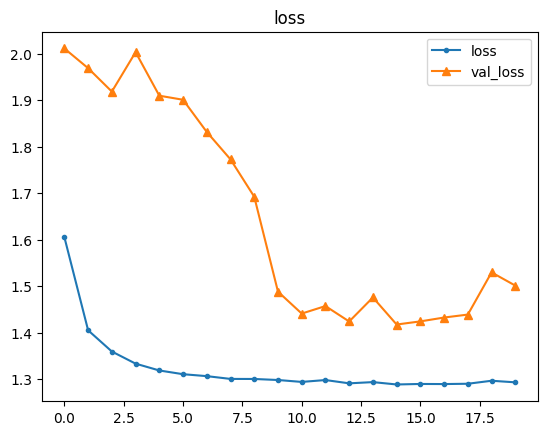

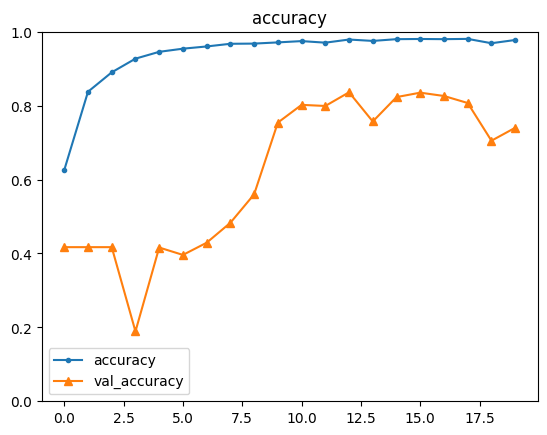

In [ ]:
df = pd.read_csv(configs.CHECKPOINTS_DIR+'classifier256/history_classifier.csv')

plt.plot(df['loss'], label='loss', marker='.')
plt.plot(df['val_loss'], label='val_loss', marker='^')
plt.legend()
plt.title('loss')
plt.show()

plt.plot(df['accuracy'], label='accuracy', marker='.')
plt.plot(df['val_accuracy'], label='val_accuracy', marker='^')
plt.legend()
plt.title('accuracy')
plt.ylim(0, 1)
plt.show()

# Evaluation

In [ ]:
model = tf.keras.models.load_model(configs.CHECKPOINTS_DIR+'/classifier256')
train_loss, train_acc = model.evaluate_generator(train_datagen, verbose=1)
val_loss, val_acc = model.evaluate_generator(val_datagen, verbose=1)
test_loss, test_acc = model.evaluate_generator(test_datagen, verbose=1)
print(train_loss, val_loss, test_loss)
print(train_acc, val_acc, test_acc)

91/91 [==============================] - 1361s 15s/step - loss: 1.4194 - accuracy: 0.8322
1.29368257522583 1.4176175594329834 1.4194022417068481
0.9750000238418579 0.8230000138282776 0.8322447538375854


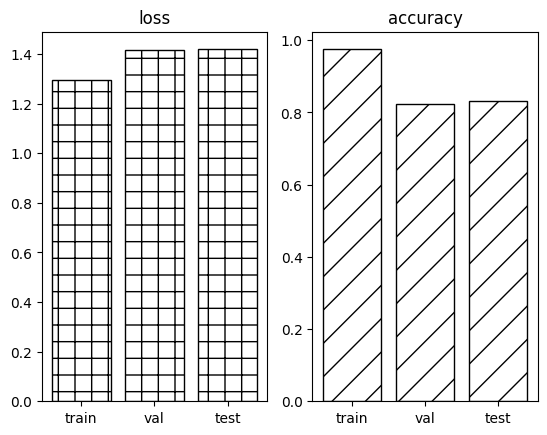

In [4]:
plt.subplot(1, 2, 1)
plt.bar(['train', 'val', 'test'], [1.2937, 1.4176, 1.4194], color='white',
                                edgecolor='black', hatch='+')
plt.title('loss')
plt.subplot(1, 2, 2)
plt.bar(['train', 'val', 'test'], [0.9750, 0.8230, 0.8322], color='white',
                                edgecolor='black', hatch='/')
plt.title('accuracy')
plt.show()